In [14]:
%matplotlib inline
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient
from influxdb import DataFrameClient
from apiclass import *
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error as mse
from pylab import rcParams

In [2]:
import sys
import warnings
import pickle
from math import *
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
query_body = """
SELECT  value

FROM meas
"""
########The database to retrieve data from ML######################
zhost = '192.168.4.33'
zport = 8086
zuser = ''
zpassword = ''
zdb_name = 'db'

#starttime = time.time()
#writer_client = DataFrameClient(host=zhost, port=zport, username=zuser, password=zpassword, database=db_name)
predictor = Online_predictor(zhost, zport, zuser, zpassword, zdb_name,query_body)
predictor.get_data_from_influx()
predictor.read_data()
df = predictor.prepare_data()
#print(df.ngp)

In [49]:
def serialize(param_data, filename,train_idx=slice(97000,100000),test_idx=slice(100000,103000), seasonal_periods=314):
    train, test = param_data.iloc[train_idx], param_data.iloc[test_idx]
    param_data.index.freq = 'sec'
### Holts-winters exponential smoothing
    model = ExponentialSmoothing(train,seasonal='add',seasonal_periods=seasonal_periods).fit()
    pred = model.predict(start=test.index[0], end=test.index[-1])
    with open('%s.pickle' %filename, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
### This function loads the model, makes a prediction and plots it.


def performance(param_data, filename):
    with open('%s.pickle'%filename, 'rb') as handle:
        model1 = pickle.load(handle)
        pred = model1.predict(start=42000, end=44999)#param_data.index[-1])
    plt.rcParams["figure.figsize"] = 20,5
    #plt.plot(train.index, train, label='Train')
    plt.plot(param_data.iloc[42000:45000], label='Test')
    plt.plot(pred, label='Holt-Winters')
    plt.legend(loc='best')
    plt.show()
    print(mse(pred,param_data.iloc[42000:45000]))

In [127]:
df_v = df['value'].copy()
df.shape
train_idx=slice(39959,42000)
test_idx=slice(42000,45000)

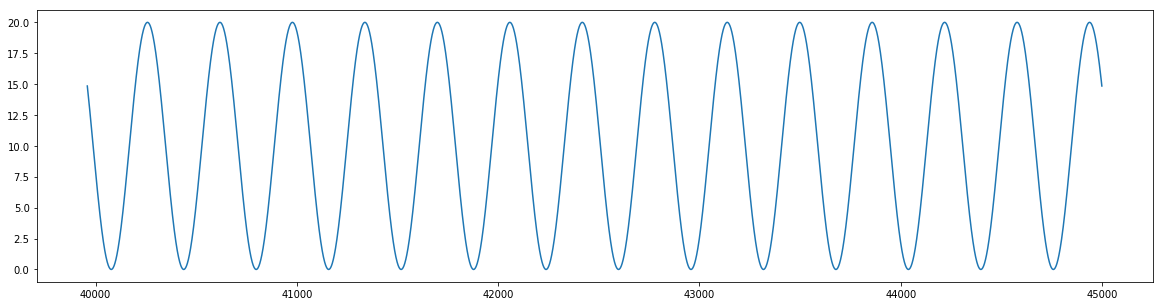

In [131]:
rcParams['figure.figsize'] = 20,5
plt.plot(df_v[39959:45000])

In [129]:
serialize(df_v ,'value',train_idx,test_idx,seasonal_periods=360)


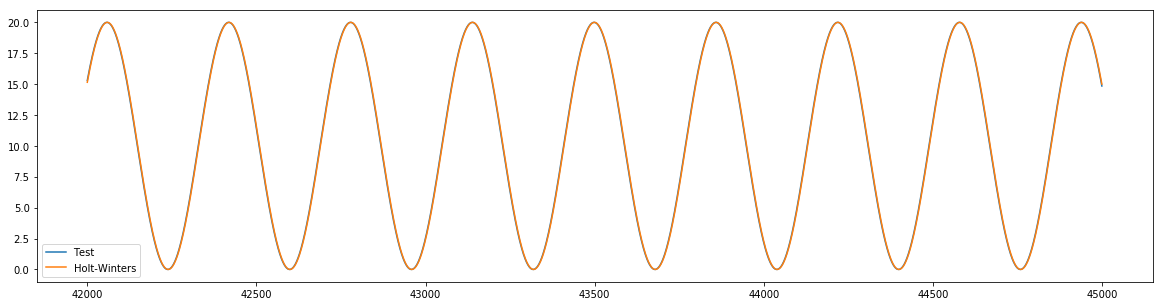

(3000,)
0.014978714852135913


In [130]:
performance(df_v,'value')